# Key-Recovery Attacks on GCM with Repeated Nonces

1. GMAC:
    AD*y^3 + C*y^2 + L*y + S
    AD = blocks of Associated Data
    C  = blocks of ciphertext
    L  = encoded length of AD and C
    S  = block used to mask the output
    y  = Authentication key

2. Attacker knows AD, C and L

3. The masking block is generated using only the key and the nonce. If
   the nonce is repeated, the mask is the same. If we can collect two
   messages encrypted under the same nonce, they'll have used the same
   mask.

4. We can recover the key by XORing the two messages together. It will cancel out the S block and leave us with the key.

in GF(2):
  Addition: XOR
  Multiplication:
  ```go
    function modmul(a, b, m):
        p := mul(a, b)
        q, r := divmod(p, m)
        return r
  ```
  or more efficiently:
  ```go
    function modmul(a, b, m):
        p := 0
        while a > 0:
            if a & 1:
                p := p ^ b
            a := a >> 1
            b := b << 1
            if deg(b) = deg(m):
                b := b ^ m
        return p
  ```

# Implement AES-GCM

It's like CTR + authentication

The GF(2^128) field used is defined by the polynomial
    x^{128}+x^{7}+x^{2}+x+1

GHASH(H,A,C) = X_m+n+1_ , where:
  H = Hash key, string of 16 zero bytes encrypted using the block cipher
  A = Associated data (not encrypted)
  C = Ciphertext (encrypted)
  X :

  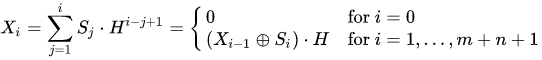

  Where S:

  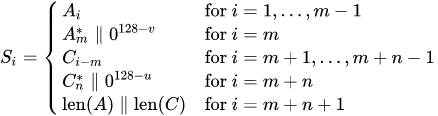
  
  A and C are 0 padded to the next multiple of 128 bits
  len(A) and len(C) are encoded as 64 bit modulo 128

  and initial counter, counter0 is:
  
  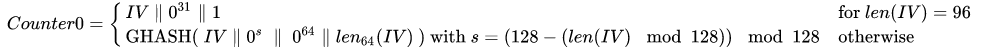

In [ ]:
from aes import BLOCKSIZE, aes_ecb_encrypt
from padding import pkcs7_pad
from utils import xor, get_blocks, ans_check

def aes_gcm_encrypt(plaintext: bytes, key: bytes, nonce: bytes) -> bytes:
    counter = b'\x00' * 16
    Ek = aes_ecb_encrypt(key, counter)
    ciphertext = xor(plaintext, Ek)

def aes_gcm_decrypt(ciphertext: bytes, key: bytes, nonce: bytes) -> bytes:
    pass

key = b'YELLOW SUBMARINE'
